# Movie Studio Projection Analysis

<div style="text-align: left;" style="border: 2px solid black;">
    <img src="https://media.istockphoto.com/id/461998989/photo/photo-of-an-old-movie-projector.jpg?s=612x612&w=0&k=20&c=U5q3IB106Zjcc5b0qDOQN1YZH4ktfaMTyVzwcuLuMfI=" alt="Airplane in Storm" width="600" height="300">
</div>

## Overview

We are studying the current movie industry in order to advise the company on the best way to open its new movie studio.  The primary factor in forming our recommendations is profitability for the studio, and we look at many variables that can help maximize returns.  Because the data used in our analysis comes from a variety of places, we select and combine the relevant pieces to provide a sound plan for launching the new studio.

## Business Problem

We want to find a movie genre that returns a high profit while requiring a relatively low budget.  In addition, we will determine a director who fits well within this space.  

Although the studio may be able to afford blockbusters down the road, we want to manage the risks of higher cost films at the beginning in order to successfully navigate entry into the business.

<div style="text-align: left;" style="border: 2px solid black;">
    <img src="https://www.valleycentral.com/wp-content/uploads/sites/39/2022/09/movie-theater-popcorn.jpg?w=2560&h=1440&crop=1" alt="Airplane in Storm" width="600" height="300">
</div>

##  Data Understanding

The data comes from multiple sources, including <a href="https://www.boxofficemojo.com/">Box Office Mojo</a>, <a href="https://www.imdb.com/">IMDB</a>, <a href="https://www.rottentomatoes.com/">Rotten Tomatoes</a>, <a href="https://www.themoviedb.org/">The Movie DB</a>, and <a href="https://www.the-numbers.com/">The Numbers</a>.  Given these different data sets, we begin by reading them and deciding which data is relevant to the questions we seek to answer.  From there, we determine how we can join together the data sets to allow us to filter what we need.

There are some limitations to the data because not all of the sources can be readily joined with each other.  Some of the information doesn't even include the titles of the movies that it is evaluating.  Furthermore, there are many more data points from some sources than there are in others, so we are not able to utilize as much information as we would like as a result of combining the larger data sets with the smaller ones.  That being said, our master data set still produces a solid number of observations that we can use.

In [3]:
import sqlite3
import pandas as pd
import numpy as np
from scipy import stats

### Movie Industry Data

After reading all of the data files provided, we identify the ones that we need for our analysis.

In [1]:
Cinema = "Data/im.db"
Budget = "Data/tn.movie_budgets.csv.gz"

In [5]:
conn = sqlite3.connect(Cinema)
cursor = conn.cursor()

### Creating a Table from our SQL data

We are creating a new table in the SQL database that includes the data we want to use from all of the other tables (persons, directors, movie_basics).

In [41]:
cursor.execute('DROP TABLE IF EXISTS Movie_info');

In [44]:
cursor.execute("""
CREATE TABLE Movie_info AS
SELECT mb.movie_id, mb.primary_title, mb.start_year, mb.genres, d.person_id, p.primary_name
FROM movie_basics mb
JOIN directors d ON mb.movie_id = d.movie_id
JOIN persons p ON d.person_id = p.person_id
WHERE mb.movie_id IS NOT NULL
    AND mb.primary_title IS NOT NULL
    AND mb.start_year IS NOT NULL
    AND mb.genres IS NOT NULL
    AND d.person_id IS NOT NULL
    AND p.primary_name IS NOT NULL
ORDER BY start_year DESC
""");

In [47]:
# Looking at new SQL table Movie_Info

pd.read_sql("""
SELECT *
FROM Movie_info
""", conn)

,movie_id,primary_title,start_year,genres,person_id,primary_name
0,tt5174640,100 Years,2115,Drama,nm0001675,Robert Rodriguez
1,tt5637536,Avatar 5,2027,"Action,Adventure,Fantasy",nm0000116,James Cameron
2,tt5637536,Avatar 5,2027,"Action,Adventure,Fantasy",nm0000116,James Cameron
3,tt3095356,Avatar 4,2025,"Action,Adventure,Fantasy",nm0000116,James Cameron
4,tt3095356,Avatar 4,2025,"Action,Adventure,Fantasy",nm0000116,James Cameron
...,...,...,...,...,...,...
284607,tt9851990,Tikiri Suwanda,2010,"Drama,Family",nm10449498,Sunil Aruna Weerasiri
284608,tt9852508,Viyapath Bambara,2010,Drama,nm10510269,Prasad De Silva
284609,tt9875120,Frostbite,2010,Documentary,nm2901551,Jorge Requena Ramos
284610,tt9875242,15 Fotografii,2010,Drama,nm2437971,Franciszek Dzida


We are reading the new SQL table and the tn.movie_budgets.csv file as pandas DataFrames.

In [48]:
Movie_Info = pd.read_sql_query("SELECT * FROM Movie_info", conn)

In [49]:
Movie_Budget = pd.read_csv(Budget)

## Data Cleaning and Preparation

In [10]:
# Renaming columns in Movie_Info for consistency

Movie_Info.rename(columns={"primary_title": "Title", "start_year": "Year", "primary_name": "Director", "genres": "Genre"}, inplace = True)

In [11]:
#Dropping columns that are not necessary

Movie_Info.drop(columns = ["movie_id", "person_id"], inplace = True)

In [12]:
#Dropping NULL values in the Genre column

Movie_Info.dropna(subset=["Genre"], inplace = True)

## Feature Engineering

After determining the [top 6 grossing movie genres](https://www.statista.com/statistics/188658/movie-genres-in-north-america-by-box-office-revenue-since-1995/), we are grouping the applicable movies in our data into those categories.

In [13]:
# Consolidating multiple genre movies into Primary Genre groups and adding that column

Movie_Info["Primary_Genre"] = Movie_Info["Genre"].apply(lambda x: "Horror" if "Horror" in x else ("Drama" if "Drama" in x else ("Animation" if "Animation" in x else ( "Sci-Fi" if "Sci-Fi" in x else ("Action" if "Action" in x else ("Comedy" if "Comedy" in x else ("Documentary" if "Documentary" in x else ("Fantasy" if "Fantasy" in x else ""))))))))

In [14]:
#Sanity check

Movie_Info.head()

,Title,Year,Genre,Director,Primary_Genre
0,100 Years,2115,Drama,Robert Rodriguez,Drama
1,Avatar 5,2027,"Action,Adventure,Fantasy",James Cameron,Action
2,Avatar 5,2027,"Action,Adventure,Fantasy",James Cameron,Action
3,Avatar 4,2025,"Action,Adventure,Fantasy",James Cameron,Action
4,Avatar 4,2025,"Action,Adventure,Fantasy",James Cameron,Action


In [15]:
# Dropping full duplicate entries

Movie_Info.drop_duplicates(inplace = True)

In [16]:
# Resetting the index

Movie_Info.reset_index(inplace = True, drop = True)

In [17]:
# Final Movie_Info DataFrame

Movie_Info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159425 entries, 0 to 159424
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Title          159425 non-null  object
 1   Year           159425 non-null  int64 
 2   Genre          159425 non-null  object
 3   Director       159425 non-null  object
 4   Primary_Genre  159425 non-null  object
dtypes: int64(1), object(4)
memory usage: 6.1+ MB


In [18]:
# Renaming columns in Movie_Budget to match those in Movie_Info
# Dropping the id column

Movie_Budget.rename(columns={"movie": "Title", "release_date": "Year", "production_budget": "Budget", "domestic_gross": "Dom_Gross", "worldwide_gross": "WW_Gross"}, inplace = True)
Movie_Budget.drop(columns = ["id"], inplace = True)

In [20]:
# Converting the Year column from an object to datetime and filtering to show the year, in order to match our Movie_Info data

Movie_Budget["Year"] = pd.to_datetime(Movie_Budget['Year'])
Movie_Budget["Year"] = Movie_Budget["Year"].dt.year

In [21]:
# Sanity check

Movie_Budget.head()

,Year,Title,Budget,Dom_Gross,WW_Gross
0,2009,Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2011,Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,2019,Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,2015,Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,2017,Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [75]:
# Merging Movie_Info and Movie_Budget together

df = pd.merge(Movie_Info, Movie_Budget, on = ["Title", "Year"])
df.head()

,Title,Year,Genre,Director,Primary_Genre,Budget,Dom_Gross,WW_Gross
0,Call of the Wild,2020,"Adventure,Animation,Family",Chris Sanders,Animation,"$82,000,000",$0,$0
1,Alita: Battle Angel,2019,"Action,Adventure,Sci-Fi",Robert Rodriguez,Sci-Fi,"$170,000,000","$85,710,210","$402,976,036"
2,Shazam!,2019,"Action,Adventure,Comedy",David F. Sandberg,Action,"$85,000,000","$139,606,856","$362,899,733"
3,Pet Sematary,2019,"Horror,Mystery,Thriller",Dennis Widmyer,Horror,"$21,000,000","$54,724,696","$109,501,146"
4,Pet Sematary,2019,"Horror,Mystery,Thriller",Kevin Kölsch,Horror,"$21,000,000","$54,724,696","$109,501,146"


In [76]:
# Filtering to only show movies from the year 2010 - 2022

df = df[(df["Year"] >= 2010) & (df["Year"] <= 2022)]

In [77]:
# Dropping entries with zero revenue

df =df.drop(df[(df["Dom_Gross"] == "$0") | (df["WW_Gross"] == "$0")].index)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1510 entries, 1 to 1693
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Title          1510 non-null   object
 1   Year           1510 non-null   int64 
 2   Genre          1510 non-null   object
 3   Director       1510 non-null   object
 4   Primary_Genre  1510 non-null   object
 5   Budget         1510 non-null   object
 6   Dom_Gross      1510 non-null   object
 7   WW_Gross       1510 non-null   object
dtypes: int64(1), object(7)
memory usage: 106.2+ KB


In [79]:
# Removing "$" and "," symbols and converting Dom_Gross and WW_Gross into intergers

df["Dom_Gross"] = df["Dom_Gross"].str.replace("$","")
df["WW_Gross"] = df["WW_Gross"].str.replace("$","")
df["Budget"] = df["Budget"].str.replace("$","")
df["Dom_Gross"] = df["Dom_Gross"].str.replace(",","")
df["WW_Gross"] = df["WW_Gross"].str.replace(",","")
df["Budget"] = df["Budget"].str.replace(",","")
df["Dom_Gross"] = df["Dom_Gross"].astype(int)
df["WW_Gross"] = df["WW_Gross"].astype(int)
df["Budget"] = df["Budget"].astype(int)

In [80]:
# Creating a Net_Profit column

df["Net_Profit"] = df["WW_Gross"] - df["Budget"]
df.head()

,Title,Year,Genre,Director,Primary_Genre,Budget,Dom_Gross,WW_Gross,Net_Profit
1,Alita: Battle Angel,2019,"Action,Adventure,Sci-Fi",Robert Rodriguez,Sci-Fi,170000000,85710210,402976036,232976036
2,Shazam!,2019,"Action,Adventure,Comedy",David F. Sandberg,Action,85000000,139606856,362899733,277899733
3,Pet Sematary,2019,"Horror,Mystery,Thriller",Dennis Widmyer,Horror,21000000,54724696,109501146,88501146
4,Pet Sematary,2019,"Horror,Mystery,Thriller",Kevin Kölsch,Horror,21000000,54724696,109501146,88501146
5,UglyDolls,2019,"Adventure,Animation,Comedy",Kelly Asbury,Animation,45000000,19894664,24644664,-20355336


In [81]:
# Creating a Return on Investment (ROI) column

df["ROI"] = round((df["Net_Profit"] / df["Budget"]) * 100, 2)

In [82]:
# Changing the column order to be more legible

new_order = ["Year", "Title", "Director", "Primary_Genre", "Genre", "Budget", "Dom_Gross", "WW_Gross", "Net_Profit", "ROI"]
df = df[new_order]

In [154]:
# Sanity check

df.head()

,Year,Title,Director,Primary_Genre,Genre,Budget,Dom_Gross,WW_Gross,Net_Profit,ROI
1,2019,Alita: Battle Angel,Robert Rodriguez,Sci-Fi,"Action,Adventure,Sci-Fi",170000000,85710210,402976036,232976036,137.04
2,2019,Shazam!,David F. Sandberg,Action,"Action,Adventure,Comedy",85000000,139606856,362899733,277899733,326.94
3,2019,Pet Sematary,Dennis Widmyer,Horror,"Horror,Mystery,Thriller",21000000,54724696,109501146,88501146,421.43
4,2019,Pet Sematary,Kevin Kölsch,Horror,"Horror,Mystery,Thriller",21000000,54724696,109501146,88501146,421.43
5,2019,UglyDolls,Kelly Asbury,Animation,"Adventure,Animation,Comedy",45000000,19894664,24644664,-20355336,-45.23


## Visual Analysis

In [84]:
import matplotlib.pyplot as plt

First, we focus on the different genres and compare the financial impacts each group has had.  We are looking to make movies with lower budgets, so the Comedy, Drama, and Horror genres stand out for that objective.

In [85]:
# Median Budget of Primary Genres

genre_Budget = df.groupby("Primary_Genre")["Budget"].median().sort_values(ascending = False).head(7)

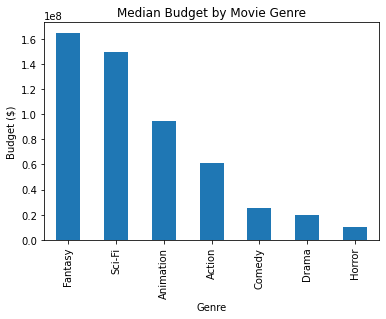

In [86]:
genre_Budget.plot(kind = "bar")
plt.xlabel("Genre")
plt.ylabel("Budget ($)")
plt.title("Median Budget by Movie Genre")
plt.show()

Next, we look at how much money has been earned from our genres.  Of the three with lower budgets, Horror has the highest median net profit.

In [87]:
# Median Net Profit of Primary Genres

genre_net_profit = df.groupby("Primary_Genre")["Net_Profit"].median().sort_values(ascending = False).head(7)

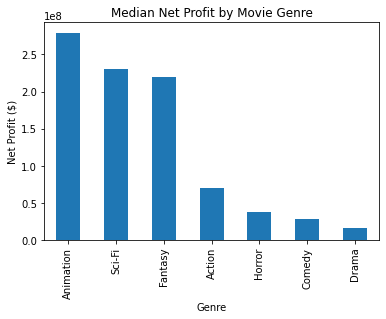

In [88]:
genre_net_profit.plot(kind = "bar")
plt.xlabel("Genre")
plt.ylabel("Net Profit ($)")
plt.title("Median Net Profit by Movie Genre")
plt.show()

In the end, we want to know which genres are the best bets to provide the greatest return on the studio's investment.  Based on the data, making movies is not a bad investment overall, but the genre that leads the way with a 270% ROI is Horror.

In [89]:
# Median ROI of Primary Genres

top_genre_highest_roi = df.groupby('Primary_Genre')['ROI'].median().sort_values(ascending=False).head(7)

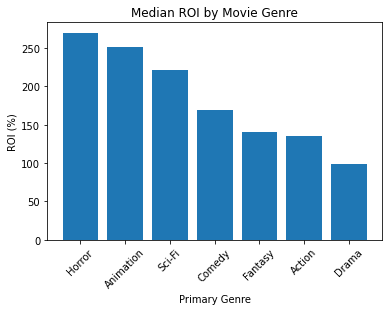

In [90]:
plt.bar(top_genre_highest_roi.index, top_genre_highest_roi.values)
plt.xlabel('Primary Genre')
plt.ylabel('ROI (%)')
plt.title('Median ROI by Movie Genre')
plt.xticks(rotation=45)
plt.show()

## Hypothesis Testing

We perform a one sample t-test in order to compare movies in the horror genre to our overall sample of movies.  

Null hypothesis (H0): the return on investment (ROI) of horror movies is less than or equal to the ROI of all movies.  

Alternative hypothesis (HA): the ROI for horror movies is significantly greater than the ROI of all movies.

We define our $\alpha$ to be $0.05$.

In [45]:
# Create an array of the ROI values for horror movies

roi_horror = np.array(df[df['Primary_Genre'] == 'Horror']['ROI'].tolist())
len(roi_horror)

153

In [46]:
# Mean and standard deviation of ROI for horror movies

print(f'Sample mean: {np.mean(roi_horror):.1f}')
print(f'Sample std: {np.std(roi_horror):.1f}')

Sample mean: 1274.9
Sample std: 4821.6


In [47]:
# Mean of ROI for the sample of all movies

roi_mean_all = df['ROI'].mean()
roi_mean_all

334.20543046357614

In [48]:
# Find the t-statistic and p-value for this test

result = stats.ttest_1samp(roi_horror, roi_mean_all)
t_stat, p_value = result
result

Ttest_1sampResult(statistic=2.4054070460022157, pvalue=0.017356261439114777)

Because this is a one sided test and ttest_1samp assumes a two sided test, we divide the p-value by 2, and p-value/2 = .0087.  Since this is less than our $\alpha$ of .05, we fail to reject our null hypothesis.  The ROI for horror movies is significantly greater than the ROI of all movies.

## Further Visual Analysis

With the information that we have learned about low budgets of horror movies, the very positive ROI of the Horror genre, and the t-test telling us that the greater ROI represents a significant difference, we turn our attention to the directors of horror movies.

In [91]:
horror_movies = df[df["Primary_Genre"] == "Horror"]
director_mean_roi = horror_movies.groupby("Director")["ROI"].mean()
sorted_directors = director_mean_roi.sort_values(ascending = False)
top_5_highest_roi_directors = sorted_directors.head(5)

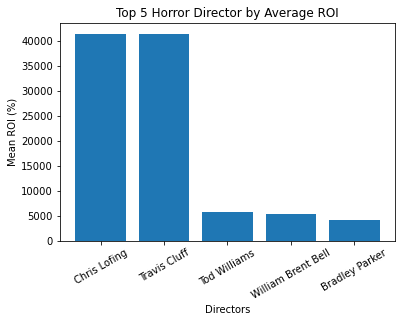

In [92]:
plt.bar(top_5_highest_roi_directors.index, top_5_highest_roi_directors.values)
plt.xlabel("Directors")
plt.ylabel("Mean ROI (%)")
plt.title("Top 5 Horror Director by Average ROI")
plt.xticks(rotation = 30)
plt.show()

Although the studio would do well to keep the budget lower at the beginning, some success in the first year or two may provide an opportunity to expand into other movie genres.  With that in mind, we look for the most successful directors by ROI of animated movies.  The median ROI in the Animation genre was very close to that of Horror, but it came with a median budget about nine times as much.

In [93]:
animation_movies = df[df["Primary_Genre"] == "Animation"]
animation_director_mean_roi = animation_movies.groupby("Director")["ROI"].mean()
sorted_animation_directors = animation_director_mean_roi.sort_values(ascending = False)
top_5_highest_animation_roi_directors = sorted_animation_directors.head(5)

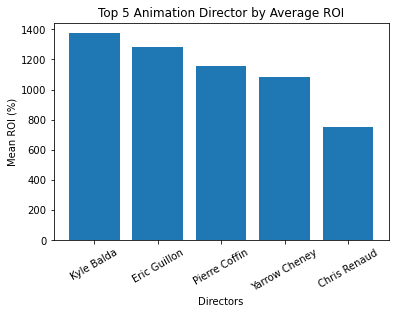

In [94]:
plt.bar(top_5_highest_animation_roi_directors.index, top_5_highest_animation_roi_directors.values)
plt.xlabel("Directors")
plt.ylabel("Mean ROI (%)")
plt.title("Top 5 Animation Director by Average ROI")
plt.xticks(rotation = 30)
plt.show()

## Simple Linear Regression

In [97]:
from scipy.stats import linregress
import seaborn as sns

- All Genres  

First, we want to look at how movie budgets affect net profits for our entire data set.  Not surprisingly, the R-value of .658 shows some positive correlation between spending money on a movie and earning profits.

In [96]:
# Simple Linear Regression for all movies

slope, intercept, r_value, p_value, std_err = linregress(df["Budget"], df["Net_Profit"])

print("Slope:", slope)
print("Intercept:", intercept)
print("R-value:", r_value)
print("P-value:", p_value)
print("Standard Error:", std_err)

Slope: 2.4133987821084992
Intercept: -4712912.030955985
R-value: 0.658465671436349
P-value: 2.3012264524504058e-188
Standard Error: 0.07103390736586021


The plot shows quite a bit of variance in the data compared to the best fit line, especially as the budgets grow.  This indicates some risk/reward tradeoff in making a movie, and the lower the budget, the less risk of negative returns.

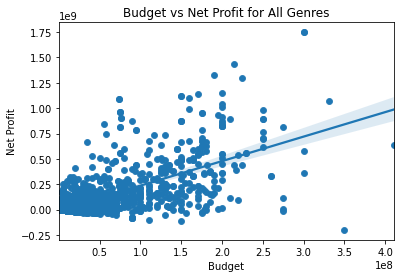

In [155]:
# Plotting the best fit line

sns.scatterplot(x='Budget', y='Net_Profit', data=df)
sns.regplot(data = df, x = "Budget", y = "Net_Profit")
plt.xlabel("Budget")
plt.ylabel("Net Profit")
plt.title("Budget vs Net Profit for All Genres")
plt.show()

- Horror Genre  

Next, we determine the relationship between budget and net profit for movies in the horror genre.  The .376 R-value still indicates some positive correlation, but the budget for a horror flick is much less responsible for its profit margin than is the case for all genres.

In [104]:
# Simple Linear Regression for horror movies only

horror_df = df[df['Primary_Genre'].str.contains('Horror')]

slope, intercept, r_value, p_value, std_err = linregress(horror_df["Budget"], horror_df["Net_Profit"])

print("Slope:", slope)
print("Intercept:", intercept)
print("R-value:", r_value)
print("P-value:", p_value)
print("Standard Error:", std_err)

Slope: 1.1855540157476705
Intercept: 40660806.49152143
R-value: 0.3761132902569564
P-value: 1.6576331662725388e-06
Standard Error: 0.23768082933150786


More good news: the data points in the regression plot for horror movies show much less residual from the line than we see in the all genres plot.  While there may be less chance to hit on a blockbuster, the downside risk of seeing a horror movie flop is far lower.  Sticking to a low budget reduces that risk even further, which is a significant consideration as a start-up studio.  Plus, there are still plenty of examples of low budget films making a very nice profit.

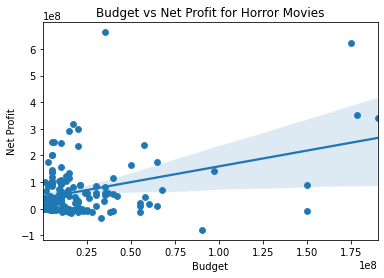

In [102]:
# Plotting the best fit line

sns.scatterplot(x='Budget', y='Net_Profit', data=horror_df)
sns.regplot(x='Budget', y='Net_Profit', data=horror_df)
plt.xlabel('Budget')
plt.ylabel('Net Profit')
plt.title("Budget vs Net Profit for Horror Movies")
plt.show()

- Animation Genre  

We also look at the same comparison for animated movies since we believe this can be a good second genre to incorporate in the future as a way to diversify the studio's offerings.  Animation requires a higher budget but has the second largest median ROI, not far behind Horror.  

The R-value for Animation is very similar to Horror, which tells us that like Horror, net profit isn't as dependent on budget as other genres can be.  Therefore, once the studio is in position to ramp up its budget per movie, animated films are a great next step.

In [105]:
# Simple Linear Regression for animation movies only

animation_df = df[df['Primary_Genre'].str.contains('Animation')]

slope, intercept, r_value, p_value, std_err = linregress(animation_df["Budget"], animation_df["Net_Profit"])

print("Slope:", slope)
print("Intercept:", intercept)
print("R-value:", r_value)
print("P-value:", p_value)
print("Standard Error:", std_err)

Slope: 2.2529548750239456
Intercept: 100548156.03643999
R-value: 0.39470195348090864
P-value: 1.2774930159712082e-06
Standard Error: 0.44483726101433785


As discussed, the budgets get higher with animated films, but the plot shows that most of these movies turn some amount of profit.  So while there is more variabilty in predicting net profit from the budget than with horror movies, there isn't as large a negative risk like some other genres.

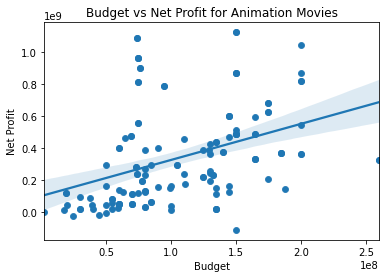

In [106]:
sns.scatterplot(x='Budget', y='Net_Profit', data=animation_df)
sns.regplot(x='Budget', y='Net_Profit', data=animation_df)
plt.xlabel('Budget')
plt.ylabel('Net Profit')
plt.title('Budget vs Net Profit for Animation Movies')
plt.show()

### Breakdown 

With the analysis of the data showing the benefit of making horror movies, we take a look at some further details.  We want to add more detail to this recommendation.

In [132]:
# Median budget of Horror movies

horror_movie = df[df["Primary_Genre"] == "Horror"]
median_horror_budget = horror_movie["Budget"].median()
median_horror_budget

10000000.0

In [133]:
# Median Net Profit of Horror movies

median_horror_net = horror_movie["Net_Profit"].median()
f"${median_horror_net:,.2f}"

'$37,203,982.00'

In [134]:
# Median ROI of Horror movies

median_horror_roi = horror_movie["ROI"].median()
median_horror_roi

270.23

What type of return on investment can be expected from a horror movie with a $10,000,000 budget?  The average ROI for such films in the data is 707%, and the middle 50% of ROI's fall between 307% and 924%.  Spending around $10 million on a horror movie indicates a great opportunity for a fantastic return!

In [145]:
horror_movie_budget = df[(df["Primary_Genre"] == "Horror") & (df["Budget"] == 10000000)]
horror_movie_budget["ROI"].describe()

count      16.000000
mean      707.393750
std       605.683351
min       -11.100000
25%       307.490000
50%       557.875000
75%       924.450000
max      2449.010000
Name: ROI, dtype: float64

The median profit of the horror movies with budgets of $10,000,000 is a very solid $55.8 million.

In [149]:
median_horror_budget_net = horror_movie_budget["Net_Profit"].median()
f"${median_horror_budget_net:,.2f}"


'$55,787,533.00'

The director hired for an initial movie should have some experience in the genre but not be so popular that his or her salary can't fit within the lower budget.  Sorting by the ROI of horror movie directors' work, we find two who far outpace the rest, as well as others who have also had extremely successful movies.  

Chris Lofing and Travis Cluff seem like outliers, so we have done some outside research involving them.  They have been nominated for awards at Indie Short Fest, as well as received other critical acclaim.  Given their popularity with audiences and critics, they both look like a pretty good match for our first project.  In addition, Lofing is a writer, producer, and director, which would be beneficial regarding costs.

In [151]:
horror_movie.groupby("Director")["ROI"].median().sort_values(ascending = False).head()

Director
Chris Lofing          41556.47
Travis Cluff          41556.47
Tod Williams           5817.07
William Brent Bell     5329.08
Bradley Parker         4141.17
Name: ROI, dtype: float64

In [71]:
# Looking at Chris Lofing movies

chris_lofing_movies = df[df["Director"] == "Chris Lofing"]
chris_lofing_movies

,Year,Title,Director,Primary_Genre,Genre,Budget,Dom_Gross,WW_Gross,Net_Profit,ROI
576,2015,The Gallows,Chris Lofing,Horror,"Horror,Mystery,Thriller",100000,22764410,41656474,41556474,41556.47


In [66]:
# Looking at Travis Cluff movies

travis_cluff_movies = df[df["Director"] == "Travis Cluff"]
travis_cluff_movies

,Year,Title,Director,Primary_Genre,Genre,Budget,Dom_Gross,WW_Gross,Net_Profit,ROI
577,2015,The Gallows,Travis Cluff,Horror,"Horror,Mystery,Thriller",100000,22764410,41656474,41556474,41556.47


Horror movie with a budget of $10,000,000 and the highest ROI:

In [73]:
highest_roi_horror_movie = horror_movie_budget.sort_values("ROI").iloc[-1]
highest_roi_horror_movie

Year                           2018
Title                     Halloween
Director         David Gordon Green
Primary_Genre                Horror
Genre               Horror,Thriller
Budget                     10000000
Dom_Gross                 159342015
WW_Gross                  254900667
Net_Profit                244900667
ROI                         2449.01
Name: 60, dtype: object

Horror movie with a budget of $10,000,000 and the lowest ROI:

In [74]:
lowest_roi_horror_movie = horror_movie_budget.sort_values("ROI").iloc[0]
lowest_roi_horror_movie

Year                               2012
Title                    The Collection
Director                 Marcus Dunstan
Primary_Genre                    Horror
Genre            Action,Horror,Thriller
Budget                         10000000
Dom_Gross                       6810754
WW_Gross                        8890094
Net_Profit                     -1109906
ROI                               -11.1
Name: 1237, dtype: object

## Recommendations  

- **Horror Movies**  
As a start-up movie studio, the focus should be horror movies due to the major success that this genre has seen over the years.  A high return on investment is most likely going to come from horror films, as seen by its leading 270% ROI.

- **$10 million budget**  
Ramping up the studio should be done patiently and intelligently, and keeping the budget on the low end minimizes risk.  In the horror genre, however, the low budget is by no means a concession to low profits.  The 270% ROI in horror climbs even higher on the lower budget films, making a $10 million budget a great bet to return a profit.  

- **Director Chris Lofing**
The ideal director for the first project is Chris Lofing, who is also a talented writer and a producer.  His combination of skills, combined with his popular and critical success, make him an obvious target to lead the studio's first effort.  If Lofing is not available initially, there are a handful of other directors that have seen their horror movies bring in profits.

## Further Investigation  

- **Marketing**  
A marketing analysis is crucial to determine the most effective strategies to promote new films.  This includes using movie trailers, media advertising, and social media content.  

- **Distribution**  
The studio also needs to investigate the avenues available to distribute movie, especially as a new player in the industry.  Partnering with a larger production company could aid in reaching a wider audience.  

- **Animation**  
As the studio grows and finds success with lower budget movies, the next phase should include looking into producing animated movies.  They generally cost more to produce, but the expected ROI for that genre is very near what horror delivers, so spending more for animation can lead to even higher profits.